<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Notes" data-toc-modified-id="Notes-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Notes</a></span><ul class="toc-item"><li><span><a href="#Current-version" data-toc-modified-id="Current-version-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Current version</a></span></li><li><span><a href="#List-of-changes" data-toc-modified-id="List-of-changes-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>List of changes</a></span></li><li><span><a href="#Todo" data-toc-modified-id="Todo-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Todo</a></span></li><li><span><a href="#Notes" data-toc-modified-id="Notes-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Notes</a></span></li></ul></li><li><span><a href="#Concatenate-FOVs,-then-crop-useful-region" data-toc-modified-id="Concatenate-FOVs,-then-crop-useful-region-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Concatenate FOVs, then crop useful region</a></span></li><li><span><a href="#Run-Registration-on-all-files" data-toc-modified-id="Run-Registration-on-all-files-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Run Registration on all files</a></span></li><li><span><a href="#Registration-with-AstroAlign----pipeline-for-transforming-and-for-checking" data-toc-modified-id="Registration-with-AstroAlign----pipeline-for-transforming-and-for-checking-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Registration with AstroAlign -- pipeline for transforming and for checking</a></span><ul class="toc-item"><li><span><a href="#Test-on-problematic-FOVs" data-toc-modified-id="Test-on-problematic-FOVs-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Test on problematic FOVs</a></span></li><li><span><a href="#Run-find-transform" data-toc-modified-id="Run-find-transform-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Run find transform</a></span></li></ul></li></ul></div>

In [10]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import cv2
import re
import os

import tifffile as tiff
from helpers import *
from astroalign_test import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
setup=2

if setup==1:

    #If fetched from the server

    Folders=dict()
    Folders['HighMag_part1']='/Volumes/prakash-lab/Projects/Octopi/3C, scan 1, part 1 split/'
    Folders['HighMag_part2']='/Volumes/prakash-lab/Projects/Octopi/3C, scan 1, part 2 split/'
    Folders['lowMag']='../3C Octopi/BGremoved/'
    Folders['HighMag_RF']='../3C Octopi/HighMag_RF/'
    Folders['Virtual']='../3C Octopi/HighMag_Tiled/'
    Folders['Aligned']='../3C Octopi/Registered/'

elif setup==2:

    #If fetched from the SSD
    Volume='/Volumes/Extreme SSD/16C/'

    Folders=dict()
    Folders['HighMag_part1']=os.path.join(Volume,'stitched/Part1/')
    Folders['HighMag_part2']=os.path.join(Volume,'stitched/Part2/')
    Folders['HighMag_part3']=os.path.join(Volume,'stitched/Part3/')
    Folders['lowMag']=os.path.join(Volume,'BGremoved/')
    Folders['HighMag_RF']=os.path.join(Volume,'HighMag_RF/')
    Folders['Virtual']=os.path.join(Volume,'HighMag_Tiled/')
    Folders['Aligned']=os.path.join(Volume,'Registered/')

In [12]:
Folders

{'HighMag_part1': '/Volumes/Extreme SSD/16C/stitched/Part1/',
 'HighMag_part2': '/Volumes/Extreme SSD/16C/stitched/Part2/',
 'HighMag_part3': '/Volumes/Extreme SSD/16C/stitched/Part3/',
 'lowMag': '/Volumes/Extreme SSD/16C/BGremoved',
 'HighMag_RF': '/Volumes/Extreme SSD/16C/HighMag_RF/',
 'Virtual': '/Volumes/Extreme SSD/16C/HighMag_Tiled/',
 'Aligned': '/Volumes/Extreme SSD/16C/Registered/'}

# Notes

## Current version

Current version is a retake of the work left a few weeks back, trying to understand how exactly it worked and what are the changes required to make it work on the three frames

## List of changes

So far I have basically changed the following: 
- fixing the number of matching points that we need
- Introduced a new type of error to allow for better debugging
- debugged the find sources function, as it seems to fail for some images in detecting the spots. Currently, I have just introduced a manual fix (manual value for thresh).


I have included a "setup" variable that designates which scenario we are in (in terms of numbering and number of parts)
- Currently we only consider two parts, neglecting the third part (relatively small anyway, and I will surely have to change things again)


## Todo

- Check the way you flip the frames, 
- Check the way the frames are renumbered as you change part in the image... You might have one too few

It seems to work for some frames but not all of them. Have to check how the switch between different frames is computed. I am confident about the flipping and rotatino, but I have to improve on the frame detection I think. 

- Understand what the origin of the Other Error is. I would have expected that we would get too few points. But I guess it is some kind of thing related to the lack of possibility of establishing a correspondence. The pictures individually have a sufficient number of points. 
- Clean the code
- Think about handling all images (fov in 5,6 for x axis, too)


- Write 16 bit

## Notes

- I did not run it with the offset (the concatenation) -- this results probably in the 11th frame to be incomplete

# Concatenate FOVs, then crop useful region

In [14]:
#high mag
pixel_size=0.365623*10**-6
# nb_pixel_y=3081
# nb_pixel_x=2755

#have to improve how this is handled
nb_pixel=dict()
nb_pixel['y']=4000
nb_pixel['x']=3000

In [15]:
#OCTOPI
fov_oct=1.6*10**-3

#These parameters have to be determined in advance, manually
#3C
if setup==1:
    offset=dict()
    offset['x']=3000*pixel_size
    offset['y']=0*pixel_size
    offset['x_part2']=260*pixel_size
    offset['y_part2']=32*pixel_size
elif setup==2:
    offset=dict()
    offset['x']=3000*pixel_size
    offset['y']=0*pixel_size
    offset['x_part2']=260*pixel_size
    offset['y_part2']=32*pixel_size

#difference on each side, manual parameter
delta=3*10**-4

In [43]:
img=concatenate_crop_ROI(nb_pixel,delta,fov_oct,Folders,offset,setup)








  0%|          | 0/144 [00:00<?, ?it/s]

_0000_0001_fluorescent.png
0_1
skipping
_0002_0002_fluorescent.png
2_2
skipping
_0006_0004_fluorescent.png
6_4
skipping
_0010_0005_fluorescent.png
10_5
_0004_0007_fluorescent.png
4_7
skipping
_0007_0002_fluorescent.png
7_2
skipping
_0011_0003_fluorescent.png
11_3
skipping
_0005_0001_fluorescent.png
5_1
skipping
_0001_0007_fluorescent.png
1_7
skipping
_0003_0004_fluorescent.png
3_4
skipping
_0004_0011_fluorescent.png
4_11
skipping
_0008_0002_fluorescent.png
8_2
skipping
_0001_0008_fluorescent.png
1_8
skipping
_0009_0004_fluorescent.png
9_4
skipping
_0001_0011_fluorescent.png
1_11
skipping
_0004_0008_fluorescent.png
4_8
skipping
_0005_0010_fluorescent.png
5_10
skipping
_0000_0009_fluorescent.png
0_9
skipping
_0009_0003_fluorescent.png
9_3
skipping
_0000_0010_fluorescent.png
0_10
skipping
_0008_0005_fluorescent.png
8_5
_0005_0009_fluorescent.png
5_9
skipping
_0003_0003_fluorescent.png
3_3
skipping
_0001_0000_fluorescent.png
1_0







 17%|█▋        | 24/144 [00:08<00:43,  2.77it/s]

_0005_0006_fluorescent.png
5_6
_0011_0004_fluorescent.png
11_4







 18%|█▊        | 26/144 [00:15<02:33,  1.30s/it]

_0007_0005_fluorescent.png
7_5
_0004_0000_fluorescent.png
4_0







 19%|█▉        | 28/144 [00:20<03:12,  1.66s/it]

_0010_0002_fluorescent.png
10_2







 20%|██        | 29/144 [00:28<06:30,  3.40s/it]

_0006_0003_fluorescent.png
6_3







 21%|██        | 30/144 [00:33<07:21,  3.87s/it]

_0002_0005_fluorescent.png
2_5
_0000_0006_fluorescent.png
0_6
_0000_0008_fluorescent.png
0_8







 23%|██▎       | 33/144 [00:38<05:59,  3.24s/it]

_0009_0002_fluorescent.png
9_2







 24%|██▎       | 34/144 [00:44<07:25,  4.05s/it]

_0005_0011_fluorescent.png
5_11
file does not exist
file does not exist







 24%|██▍       | 35/144 [00:47<07:00,  3.86s/it]

_0005_0008_fluorescent.png
5_8







 25%|██▌       | 36/144 [00:52<07:35,  4.21s/it]

_0000_0011_fluorescent.png
0_11
file does not exist
file does not exist







 26%|██▌       | 37/144 [00:56<07:19,  4.11s/it]

_0008_0004_fluorescent.png
8_4







 26%|██▋       | 38/144 [01:02<08:26,  4.78s/it]

_0005_0007_fluorescent.png
5_7







 27%|██▋       | 39/144 [01:07<08:18,  4.75s/it]

_0011_0005_fluorescent.png
11_5
_0007_0004_fluorescent.png
7_4







 28%|██▊       | 41/144 [01:12<06:52,  4.01s/it]

_0003_0002_fluorescent.png
3_2







 29%|██▉       | 42/144 [01:17<07:17,  4.29s/it]

_0001_0001_fluorescent.png
1_1







 30%|██▉       | 43/144 [01:23<08:23,  4.99s/it]

_0002_0004_fluorescent.png
2_4







 31%|███       | 44/144 [01:30<09:02,  5.43s/it]

_0000_0007_fluorescent.png
0_7







 31%|███▏      | 45/144 [01:35<08:54,  5.39s/it]

_0004_0001_fluorescent.png
4_1







 32%|███▏      | 46/144 [01:40<08:44,  5.35s/it]

_0010_0003_fluorescent.png
10_3







 33%|███▎      | 47/144 [01:47<09:16,  5.74s/it]

_0006_0002_fluorescent.png
6_2







 33%|███▎      | 48/144 [01:52<08:49,  5.52s/it]

_0006_0005_fluorescent.png
6_5
_0010_0004_fluorescent.png
10_4







 35%|███▍      | 50/144 [01:58<07:25,  4.74s/it]

_0004_0006_fluorescent.png
4_6
_0000_0000_fluorescent.png
0_0







 36%|███▌      | 52/144 [02:03<06:17,  4.10s/it]

_0002_0003_fluorescent.png
2_3







 37%|███▋      | 53/144 [02:10<07:27,  4.91s/it]

_0001_0006_fluorescent.png
1_6
_0003_0005_fluorescent.png
3_5
_0007_0003_fluorescent.png
7_3







 39%|███▉      | 56/144 [02:16<05:53,  4.02s/it]

_0011_0002_fluorescent.png
11_2







 40%|███▉      | 57/144 [02:22<06:54,  4.77s/it]

_0005_0000_fluorescent.png
5_0







 40%|████      | 58/144 [02:27<06:56,  4.84s/it]

_0008_0003_fluorescent.png
8_3







 41%|████      | 59/144 [02:33<07:21,  5.19s/it]

_0001_0009_fluorescent.png
1_9







 42%|████▏     | 60/144 [02:39<07:44,  5.53s/it]

_0004_0010_fluorescent.png
4_10







 42%|████▏     | 61/144 [02:45<07:30,  5.42s/it]

_0004_0009_fluorescent.png
4_9







 43%|████▎     | 62/144 [02:49<07:10,  5.25s/it]

_0009_0005_fluorescent.png
9_5
_0001_0010_fluorescent.png
1_10







 44%|████▍     | 64/144 [02:56<06:07,  4.60s/it]

_0007_0009_fluorescent.png
7_9







 45%|████▌     | 65/144 [03:01<06:15,  4.75s/it]

_0011_0008_fluorescent.png
11_8







 46%|████▌     | 66/144 [03:07<06:45,  5.20s/it]

_0002_0010_fluorescent.png
2_10







 47%|████▋     | 67/144 [03:13<07:07,  5.55s/it]

_0008_0006_fluorescent.png
8_6
_0002_0009_fluorescent.png
2_9







 48%|████▊     | 69/144 [03:20<06:01,  4.81s/it]

_0009_0000_fluorescent.png
9_0







 49%|████▊     | 70/144 [03:26<06:35,  5.35s/it]

_0011_0011_fluorescent.png
11_11
file does not exist
file does not exist
file does not exist







 49%|████▉     | 71/144 [03:31<06:22,  5.24s/it]

_0007_0010_fluorescent.png
7_10







 50%|█████     | 72/144 [03:37<06:35,  5.49s/it]

_0002_0006_fluorescent.png
2_6
_0000_0005_fluorescent.png
0_5
_0008_0010_fluorescent.png
8_10







 52%|█████▏    | 75/144 [03:44<05:11,  4.52s/it]

_0010_0001_fluorescent.png
10_1







 53%|█████▎    | 76/144 [03:50<05:47,  5.12s/it]

_0004_0003_fluorescent.png
4_3







 53%|█████▎    | 77/144 [03:55<05:40,  5.08s/it]

_0006_0000_fluorescent.png
6_0







 54%|█████▍    | 78/144 [04:01<05:35,  5.08s/it]

_0011_0007_fluorescent.png
11_7







 55%|█████▍    | 79/144 [04:07<05:54,  5.46s/it]

_0005_0005_fluorescent.png
5_5
_0007_0006_fluorescent.png
7_6
_0003_0000_fluorescent.png
3_0







 57%|█████▋    | 82/144 [04:12<04:27,  4.32s/it]

_0008_0009_fluorescent.png
8_9







 58%|█████▊    | 83/144 [04:18<04:59,  4.92s/it]

_0001_0003_fluorescent.png
1_3







 58%|█████▊    | 84/144 [04:25<05:19,  5.33s/it]

_0009_0011_fluorescent.png
9_11
file does not exist
file does not exist
file does not exist







 59%|█████▉    | 85/144 [04:30<05:09,  5.24s/it]

_0001_0004_fluorescent.png
1_4







 60%|█████▉    | 86/144 [04:35<05:11,  5.37s/it]

_0003_0007_fluorescent.png
3_7







 60%|██████    | 87/144 [04:40<05:01,  5.29s/it]

_0007_0001_fluorescent.png
7_1







 61%|██████    | 88/144 [04:46<05:02,  5.41s/it]

_0005_0002_fluorescent.png
5_2







 62%|██████▏   | 89/144 [04:52<05:10,  5.64s/it]

_0011_0000_fluorescent.png
11_0







 62%|██████▎   | 90/144 [04:59<05:30,  6.12s/it]

_0006_0007_fluorescent.png
6_7







 63%|██████▎   | 91/144 [05:05<05:10,  5.85s/it]

_0004_0004_fluorescent.png
4_4







 64%|██████▍   | 92/144 [05:10<04:50,  5.59s/it]

_0010_0006_fluorescent.png
10_6
_0000_0002_fluorescent.png
0_2







 65%|██████▌   | 94/144 [05:15<03:53,  4.67s/it]

_0009_0008_fluorescent.png
9_8







 66%|██████▌   | 95/144 [05:22<04:21,  5.33s/it]

_0002_0001_fluorescent.png
2_1







 67%|██████▋   | 96/144 [05:28<04:28,  5.60s/it]

_0010_0009_fluorescent.png
10_9







 67%|██████▋   | 97/144 [05:34<04:30,  5.76s/it]

_0006_0008_fluorescent.png
6_8







 68%|██████▊   | 98/144 [05:39<04:13,  5.52s/it]

_0009_0007_fluorescent.png
9_7







 69%|██████▉   | 99/144 [05:45<04:17,  5.71s/it]

_0003_0011_fluorescent.png
3_11
file does not exist
file does not exist







 69%|██████▉   | 100/144 [05:48<03:40,  5.02s/it]

_0008_0001_fluorescent.png
8_1







 70%|███████   | 101/144 [05:55<03:53,  5.44s/it]

_0003_0008_fluorescent.png
3_8







 71%|███████   | 102/144 [06:00<03:42,  5.30s/it]

_0006_0011_fluorescent.png
6_11
file does not exist
file does not exist







 72%|███████▏  | 103/144 [06:04<03:19,  4.88s/it]

_0010_0010_fluorescent.png
10_10







 72%|███████▏  | 104/144 [06:10<03:31,  5.28s/it]

_0007_0000_fluorescent.png
7_0







 73%|███████▎  | 105/144 [06:15<03:23,  5.21s/it]

_0005_0003_fluorescent.png
5_3







 74%|███████▎  | 106/144 [06:20<03:13,  5.10s/it]

_0011_0001_fluorescent.png
11_1







 74%|███████▍  | 107/144 [06:26<03:22,  5.49s/it]

_0009_0010_fluorescent.png
9_10







 75%|███████▌  | 108/144 [06:33<03:26,  5.72s/it]

_0001_0005_fluorescent.png
1_5
_0003_0006_fluorescent.png
3_6
_0000_0003_fluorescent.png
0_3







 77%|███████▋  | 111/144 [06:37<02:28,  4.50s/it]

_0002_0000_fluorescent.png
2_0







 78%|███████▊  | 112/144 [06:44<02:43,  5.11s/it]

_0009_0009_fluorescent.png
9_9







 78%|███████▊  | 113/144 [06:50<02:49,  5.48s/it]

_0006_0006_fluorescent.png
6_6
_0004_0005_fluorescent.png
4_5
_0010_0007_fluorescent.png
10_7







 81%|████████  | 116/144 [06:58<02:09,  4.62s/it]

_0009_0006_fluorescent.png
9_6
_0003_0010_fluorescent.png
3_10







 82%|████████▏ | 118/144 [07:03<01:44,  4.03s/it]

_0010_0008_fluorescent.png
10_8







 83%|████████▎ | 119/144 [07:10<01:57,  4.68s/it]

_0006_0009_fluorescent.png
6_9







 83%|████████▎ | 120/144 [07:15<01:56,  4.86s/it]

_0006_0010_fluorescent.png
6_10







 84%|████████▍ | 121/144 [07:20<01:51,  4.84s/it]

_0010_0011_fluorescent.png
10_11
file does not exist
file does not exist
file does not exist







 85%|████████▍ | 122/144 [07:25<01:46,  4.85s/it]

_0003_0009_fluorescent.png
3_9







 85%|████████▌ | 123/144 [07:29<01:40,  4.79s/it]

_0008_0000_fluorescent.png
8_0







 86%|████████▌ | 124/144 [07:36<01:46,  5.32s/it]

_0002_0011_fluorescent.png
2_11
file does not exist
file does not exist
file does not exist







 87%|████████▋ | 125/144 [07:41<01:38,  5.18s/it]

_0008_0007_fluorescent.png
8_7







 88%|████████▊ | 126/144 [07:47<01:40,  5.56s/it]

_0007_0008_fluorescent.png
7_8







 88%|████████▊ | 127/144 [07:52<01:31,  5.38s/it]

_0011_0009_fluorescent.png
11_9







 89%|████████▉ | 128/144 [07:58<01:31,  5.69s/it]

_0011_0010_fluorescent.png
11_10







 90%|████████▉ | 129/144 [08:05<01:27,  5.83s/it]

_0007_0011_fluorescent.png
7_11
file does not exist
file does not exist







 90%|█████████ | 130/144 [08:09<01:13,  5.24s/it]

_0009_0001_fluorescent.png
9_1







 91%|█████████ | 131/144 [08:15<01:13,  5.62s/it]

_0002_0008_fluorescent.png
2_8







 92%|█████████▏| 132/144 [08:22<01:10,  5.89s/it]

_0010_0000_fluorescent.png
10_0







 92%|█████████▏| 133/144 [08:28<01:06,  6.03s/it]

_0004_0002_fluorescent.png
4_2







 93%|█████████▎| 134/144 [08:33<00:57,  5.73s/it]

_0006_0001_fluorescent.png
6_1







 94%|█████████▍| 135/144 [08:38<00:49,  5.55s/it]

_0002_0007_fluorescent.png
2_7







 94%|█████████▍| 136/144 [08:44<00:45,  5.74s/it]

_0000_0004_fluorescent.png
0_4







 95%|█████████▌| 137/144 [08:49<00:38,  5.55s/it]

_0008_0011_fluorescent.png
8_11
file does not exist
file does not exist
file does not exist







 96%|█████████▌| 138/144 [08:54<00:32,  5.37s/it]

_0008_0008_fluorescent.png
8_8







 97%|█████████▋| 139/144 [09:01<00:28,  5.70s/it]

_0003_0001_fluorescent.png
3_1







 97%|█████████▋| 140/144 [09:06<00:22,  5.51s/it]

_0001_0002_fluorescent.png
1_2







 98%|█████████▊| 141/144 [09:12<00:17,  5.79s/it]

_0011_0006_fluorescent.png
11_6
_0005_0004_fluorescent.png
5_4







 99%|█████████▉| 143/144 [09:18<00:04,  4.88s/it]

_0007_0007_fluorescent.png
7_7







100%|██████████| 144/144 [09:23<00:00,  4.93s/it]

# Run Registration on all files

In [ ]:
th=150
run_registration(Folders,th,setup)







  0%|          | 0/144 [00:00<?, ?it/s]

_0000_0001_fluorescent.png








  1%|          | 1/144 [00:01<03:26,  1.45s/it]

_0002_0002_fluorescent.png








  1%|▏         | 2/144 [00:02<03:21,  1.42s/it]

_0006_0004_fluorescent.png








  2%|▏         | 3/144 [00:08<06:01,  2.57s/it]

_0010_0005_fluorescent.png
_0004_0007_fluorescent.png








  3%|▎         | 5/144 [00:23<09:39,  4.17s/it]

_0007_0002_fluorescent.png








  4%|▍         | 6/144 [00:25<07:49,  3.40s/it]

_0011_0003_fluorescent.png








  5%|▍         | 7/144 [00:29<08:22,  3.67s/it]

_0005_0001_fluorescent.png








  6%|▌         | 8/144 [00:34<08:48,  3.89s/it]

_0001_0007_fluorescent.png








  6%|▋         | 9/144 [00:35<07:21,  3.27s/it]

_0003_0004_fluorescent.png








  7%|▋         | 10/144 [00:41<08:58,  4.02s/it]

_0004_0011_fluorescent.png








  8%|▊         | 11/144 [00:48<10:32,  4.76s/it]

_0008_0002_fluorescent.png








  8%|▊         | 12/144 [00:54<11:27,  5.21s/it]

_0001_0008_fluorescent.png








  9%|▉         | 13/144 [00:55<08:56,  4.09s/it]

_0009_0004_fluorescent.png








 10%|▉         | 14/144 [01:00<09:16,  4.28s/it]

_0001_0011_fluorescent.png








 10%|█         | 15/144 [01:02<07:21,  3.42s/it]

_0004_0008_fluorescent.png








 11%|█         | 16/144 [01:07<08:34,  4.02s/it]

_0005_0010_fluorescent.png








 12%|█▏        | 17/144 [01:19<13:24,  6.34s/it]

_0000_0009_fluorescent.png








 12%|█▎        | 18/144 [01:20<10:03,  4.79s/it]

_0009_0003_fluorescent.png








 13%|█▎        | 19/144 [01:24<09:36,  4.61s/it]

_0000_0010_fluorescent.png








 14%|█▍        | 20/144 [01:26<07:38,  3.70s/it]

_0008_0005_fluorescent.png
_0005_0009_fluorescent.png








 15%|█▌        | 22/144 [01:33<07:30,  3.69s/it]

_0003_0003_fluorescent.png








 16%|█▌        | 23/144 [01:37<07:48,  3.87s/it]

_0001_0000_fluorescent.png








 17%|█▋        | 24/144 [01:39<06:09,  3.08s/it]

_0005_0006_fluorescent.png
_0011_0004_fluorescent.png








 18%|█▊        | 26/144 [01:44<05:46,  2.94s/it]

_0007_0005_fluorescent.png
_0004_0000_fluorescent.png








 19%|█▉        | 28/144 [01:46<04:33,  2.36s/it]

_0010_0002_fluorescent.png








 20%|██        | 29/144 [01:51<05:58,  3.12s/it]

_0006_0003_fluorescent.png








 21%|██        | 30/144 [01:54<05:50,  3.08s/it]

_0002_0005_fluorescent.png
_0000_0006_fluorescent.png
_0000_0008_fluorescent.png








 23%|██▎       | 33/144 [01:55<04:16,  2.31s/it]

_0009_0002_fluorescent.png








 24%|██▎       | 34/144 [02:01<06:02,  3.29s/it]

_0005_0011_fluorescent.png








 24%|██▍       | 35/144 [02:05<06:33,  3.61s/it]

_0005_0008_fluorescent.png








 25%|██▌       | 36/144 [02:16<10:36,  5.89s/it]

_0000_0011_fluorescent.png








 26%|██▌       | 37/144 [02:18<08:06,  4.55s/it]

_0008_0004_fluorescent.png








 26%|██▋       | 38/144 [02:23<08:17,  4.69s/it]

_0005_0007_fluorescent.png








 27%|██▋       | 39/144 [02:25<07:04,  4.04s/it]

_0011_0005_fluorescent.png
_0007_0004_fluorescent.png








 28%|██▊       | 41/144 [02:31<06:15,  3.65s/it]

_0003_0002_fluorescent.png








 29%|██▉       | 42/144 [02:35<06:29,  3.82s/it]

_0001_0001_fluorescent.png








 30%|██▉       | 43/144 [02:39<06:30,  3.87s/it]

_0002_0004_fluorescent.png








 31%|███       | 44/144 [02:40<05:08,  3.09s/it]

_0000_0007_fluorescent.png








 31%|███▏      | 45/144 [02:42<04:16,  2.59s/it]

_0004_0001_fluorescent.png








 32%|███▏      | 46/144 [02:46<05:02,  3.09s/it]

_0010_0003_fluorescent.png








 33%|███▎      | 47/144 [02:51<05:48,  3.59s/it]

_0006_0002_fluorescent.png








 33%|███▎      | 48/144 [02:55<06:11,  3.87s/it]

_0006_0005_fluorescent.png
_0010_0004_fluorescent.png








 35%|███▍      | 50/144 [03:00<05:20,  3.41s/it]

_0004_0006_fluorescent.png
_0000_0000_fluorescent.png








 36%|███▌      | 52/144 [03:04<04:40,  3.05s/it]

_0002_0003_fluorescent.png








 37%|███▋      | 53/144 [03:06<03:48,  2.51s/it]

_0001_0006_fluorescent.png
_0003_0005_fluorescent.png
_0007_0003_fluorescent.png








 39%|███▉      | 56/144 [03:13<03:43,  2.54s/it]

_0011_0002_fluorescent.png








 40%|███▉      | 57/144 [03:15<03:13,  2.22s/it]

_0005_0000_fluorescent.png








 40%|████      | 58/144 [03:16<02:51,  2.00s/it]

_0008_0003_fluorescent.png








 41%|████      | 59/144 [03:20<03:19,  2.35s/it]

_0001_0009_fluorescent.png








 42%|████▏     | 60/144 [03:21<02:59,  2.14s/it]

_0004_0010_fluorescent.png








 42%|████▏     | 61/144 [03:40<09:50,  7.11s/it]

_0004_0009_fluorescent.png








 43%|████▎     | 62/144 [03:43<08:14,  6.04s/it]

_0009_0005_fluorescent.png
_0001_0010_fluorescent.png








 44%|████▍     | 64/144 [03:45<06:01,  4.52s/it]

_0007_0009_fluorescent.png








 45%|████▌     | 65/144 [04:05<12:02,  9.14s/it]

_0011_0008_fluorescent.png








 46%|████▌     | 66/144 [05:59<52:46, 40.59s/it]

_0002_0010_fluorescent.png








 47%|████▋     | 67/144 [06:01<37:04, 28.89s/it]

_0008_0006_fluorescent.png
_0002_0009_fluorescent.png








 48%|████▊     | 69/144 [06:03<25:41, 20.55s/it]

_0009_0000_fluorescent.png








 49%|████▊     | 70/144 [06:10<20:21, 16.50s/it]

_0011_0011_fluorescent.png








 49%|████▉     | 71/144 [09:56<1:36:18, 79.16s/it]

_0007_0010_fluorescent.png








 50%|█████     | 72/144 [10:02<1:08:46, 57.31s/it]





 51%|█████▏    | 74/144 [10:02<46:49, 40.13s/it]  

_0002_0006_fluorescent.png
_0000_0005_fluorescent.png
_0008_0010_fluorescent.png








 52%|█████▏    | 75/144 [10:26<40:45, 35.44s/it]

_0010_0001_fluorescent.png








 53%|█████▎    | 76/144 [10:33<30:12, 26.66s/it]

_0004_0003_fluorescent.png








 53%|█████▎    | 77/144 [10:37<22:19, 19.99s/it]

_0006_0000_fluorescent.png








 54%|█████▍    | 78/144 [10:45<17:55, 16.30s/it]

_0011_0007_fluorescent.png








 55%|█████▍    | 79/144 [13:36<1:08:11, 62.95s/it]

_0005_0005_fluorescent.png
_0007_0006_fluorescent.png
_0003_0000_fluorescent.png








 57%|█████▋    | 82/144 [13:41<46:00, 44.52s/it]  

_0008_0009_fluorescent.png








 58%|█████▊    | 83/144 [14:19<43:08, 42.43s/it]

_0001_0003_fluorescent.png








 58%|█████▊    | 84/144 [14:20<30:09, 30.16s/it]

_0009_0011_fluorescent.png








 59%|█████▉    | 85/144 [14:30<23:44, 24.15s/it]

_0001_0004_fluorescent.png








 60%|█████▉    | 86/144 [14:31<16:41, 17.27s/it]

_0003_0007_fluorescent.png








 60%|██████    | 87/144 [14:42<14:36, 15.38s/it]

_0007_0001_fluorescent.png








 61%|██████    | 88/144 [14:48<11:37, 12.45s/it]

_0005_0002_fluorescent.png








 62%|██████▏   | 89/144 [14:49<08:20,  9.11s/it]

_0011_0000_fluorescent.png








 62%|██████▎   | 90/144 [14:54<07:04,  7.86s/it]

_0006_0007_fluorescent.png








 63%|██████▎   | 91/144 [15:04<07:27,  8.45s/it]

_0004_0004_fluorescent.png








 64%|██████▍   | 92/144 [15:09<06:29,  7.49s/it]

_0010_0006_fluorescent.png
_0000_0002_fluorescent.png








 65%|██████▌   | 94/144 [15:11<04:33,  5.46s/it]

_0009_0008_fluorescent.png








 66%|██████▌   | 95/144 [15:26<06:46,  8.30s/it]

_0002_0001_fluorescent.png








 67%|██████▋   | 96/144 [15:30<05:41,  7.11s/it]

_0010_0009_fluorescent.png








 67%|██████▋   | 97/144 [16:14<14:12, 18.14s/it]

_0006_0008_fluorescent.png








 68%|██████▊   | 98/144 [16:30<13:18, 17.35s/it]

_0009_0007_fluorescent.png








 69%|██████▉   | 99/144 [16:40<11:21, 15.14s/it]

_0003_0011_fluorescent.png








 69%|██████▉   | 100/144 [16:42<08:13, 11.21s/it]

_0008_0001_fluorescent.png








 70%|███████   | 101/144 [16:49<07:17, 10.18s/it]

_0003_0008_fluorescent.png








 71%|███████   | 102/144 [16:54<05:57,  8.52s/it]

_0006_0011_fluorescent.png








 72%|███████▏  | 103/144 [18:41<26:05, 38.19s/it]

_0010_0010_fluorescent.png








 72%|███████▏  | 104/144 [19:05<22:36, 33.92s/it]

_0007_0000_fluorescent.png








 73%|███████▎  | 105/144 [19:08<15:58, 24.58s/it]

_0005_0003_fluorescent.png








 74%|███████▎  | 106/144 [19:13<11:45, 18.57s/it]

_0011_0001_fluorescent.png








 74%|███████▍  | 107/144 [19:17<08:47, 14.25s/it]

_0009_0010_fluorescent.png








 75%|███████▌  | 108/144 [19:33<08:48, 14.67s/it]

_0001_0005_fluorescent.png
_0003_0006_fluorescent.png
_0000_0003_fluorescent.png








 77%|███████▋  | 111/144 [19:34<05:43, 10.40s/it]

_0002_0000_fluorescent.png








 78%|███████▊  | 112/144 [19:35<04:05,  7.68s/it]

_0009_0009_fluorescent.png








 78%|███████▊  | 113/144 [20:23<10:08, 19.65s/it]

_0006_0006_fluorescent.png
_0004_0005_fluorescent.png
_0010_0007_fluorescent.png








 81%|████████  | 116/144 [23:11<14:17, 30.62s/it]

_0009_0006_fluorescent.png
_0003_0010_fluorescent.png








 82%|████████▏ | 118/144 [23:15<09:31, 21.97s/it]

_0010_0008_fluorescent.png








 83%|████████▎ | 119/144 [28:57<49:13, 118.13s/it]

_0006_0009_fluorescent.png








 83%|████████▎ | 120/144 [29:16<35:16, 88.19s/it] 

_0006_0010_fluorescent.png








 84%|████████▍ | 121/144 [31:34<39:35, 103.27s/it]

_0010_0011_fluorescent.png








 85%|████████▍ | 122/144 [33:40<40:22, 110.13s/it]

_0003_0009_fluorescent.png








 85%|████████▌ | 123/144 [33:43<27:14, 77.83s/it] 

_0008_0000_fluorescent.png








 86%|████████▌ | 124/144 [33:50<18:55, 56.76s/it]

_0002_0011_fluorescent.png








 87%|████████▋ | 125/144 [33:55<13:00, 41.08s/it]

_0008_0007_fluorescent.png








 88%|████████▊ | 126/144 [36:34<22:55, 76.42s/it]

_0007_0008_fluorescent.png








 88%|████████▊ | 127/144 [36:44<16:02, 56.62s/it]

_0011_0009_fluorescent.png








 89%|████████▉ | 128/144 [37:42<15:09, 56.82s/it]

_0011_0010_fluorescent.png








 90%|████████▉ | 129/144 [46:17<48:35, 194.38s/it]

_0007_0011_fluorescent.png








 90%|█████████ | 130/144 [46:19<31:54, 136.76s/it]

_0009_0001_fluorescent.png








 91%|█████████ | 131/144 [46:21<20:50, 96.16s/it] 

_0002_0008_fluorescent.png








 92%|█████████▏| 132/144 [46:29<13:56, 69.74s/it]

_0010_0000_fluorescent.png








 92%|█████████▏| 133/144 [46:31<09:06, 49.64s/it]

_0004_0002_fluorescent.png








 93%|█████████▎| 134/144 [46:36<06:01, 36.19s/it]

_0006_0001_fluorescent.png








 94%|█████████▍| 135/144 [46:41<04:00, 26.69s/it]

_0002_0007_fluorescent.png








 94%|█████████▍| 136/144 [46:42<02:33, 19.13s/it]

_0000_0004_fluorescent.png








 95%|█████████▌| 137/144 [46:44<01:36, 13.82s/it]

_0008_0011_fluorescent.png








 96%|█████████▌| 138/144 [46:52<01:13, 12.25s/it]

_0008_0008_fluorescent.png


# Registration with AstroAlign -- pipeline for transforming and for checking

Source : https://github.com/toros-astro/astroalign/blob/master/README.md

## Test on problematic FOVs

In [12]:

img_virtual=cv2.imread(Folders['Virtual']+'1_1.png',0)
img_lowMag=cv2.imread(Folders['lowMag']+'_01_01_fluorescent_linearRGB.png',0)


In [13]:
th=150
img_virtual_bin=binarize_img(img_virtual,th,True)
img_lowMag_bin=binarize_img(img_lowMag,th,False)

In [28]:
sources_lM=_find_sources(img_lowMag_bin)
sources_lM.shape

(9, 2)

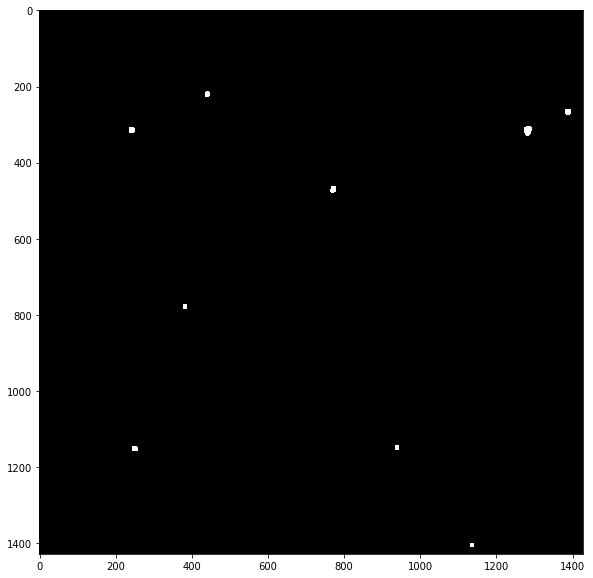

In [25]:
plt.figure(figsize=(10,10))
plt.imshow(img_lowMag_bin,cmap='gray', vmin=0, vmax=255)

In [30]:
sources_virtual=_find_sources(img_virtual_bin)
sources_virtual.shape

(0,)

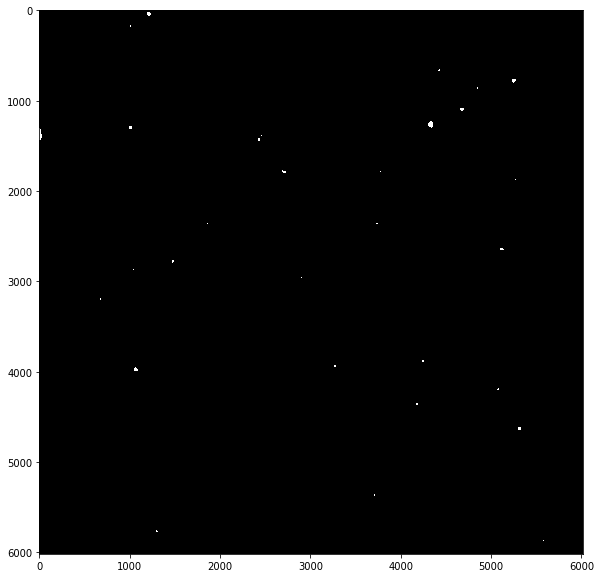

In [24]:
plt.figure(figsize=(10,10))
plt.imshow(img_virtual_bin,cmap='gray', vmin=0, vmax=255)

## Run find transform

In [27]:
from astroalign_test import *

In [54]:
transf, (pos_img_virtual, pos_img_lM) = find_transform(img_virtual_bin, img_lowMag_bin)

shape of source
(30, 2)
shape of target
(9, 2)
checking the number of control points
30
9


In [55]:
registered_image = apply_transform(transf,img_virtual, img_lowMag)
img_aligned=registered_image[0]*3

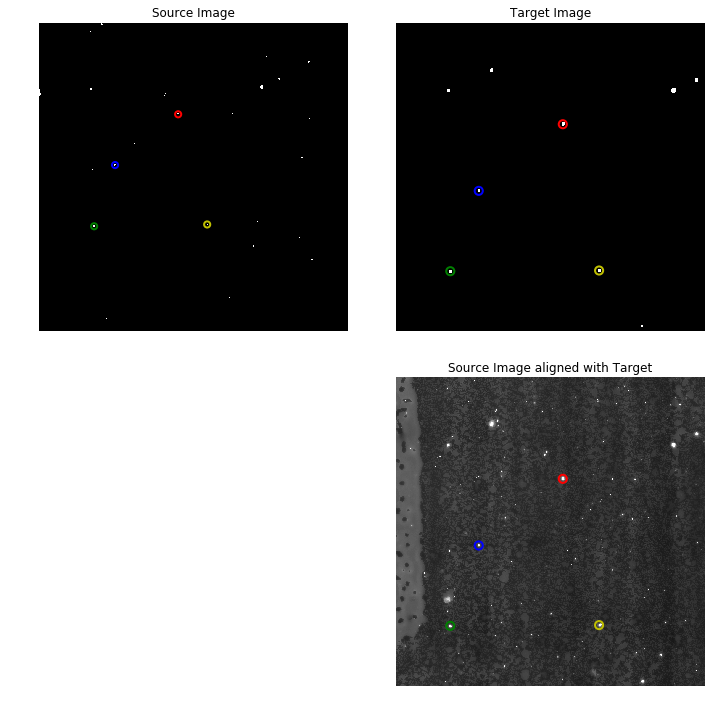

In [56]:
r=60
viz_ref_points(img_virtual_bin,img_lowMag_bin,img_aligned,transf,pos_img_virtual,pos_img_lM,r,circles=True)